<h1 style="text-align: center; font-family: Verdana; font-size: 32px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; font-variant: small-caps; letter-spacing: 3px; color: #000000; background-color: #ffffff;">Exploratory Data Analysis</h1>

<br><br>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: navy; background-color: #ffffff;">TABLE OF CONTENTS</h2>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#imports">0&nbsp;&nbsp;&nbsp;&nbsp;IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#setup">1&nbsp;&nbsp;&nbsp;&nbsp;SETUP & PREPROCESSING</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#openslide">2&nbsp;&nbsp;&nbsp;&nbsp;INVESTIGATE THE SLIDES USING OPENSLIDE</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#heuristic">3&nbsp;&nbsp;&nbsp;&nbsp;HUERISTIC EXPLORATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#class_viz">4&nbsp;&nbsp;&nbsp;&nbsp;CLASSWISE VISUALIZATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#slide_classification">5&nbsp;&nbsp;&nbsp;&nbsp;HEURISTIC FOR SLIDE CLASSIFICATION FROM TILE LABELS</a></h3>

---

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="imports">0&nbsp;&nbsp;IMPORTS</a>

In [1]:
# Data Science Imports
from sklearn.tree import _tree
from sklearn import tree
import pandas as pd; pd.options.mode.chained_assignment=None;
import numpy as np

# Domain Related Imports
from google.cloud import storage
import openslide
import tifffile

# Built-In Imports
import math
import PIL
import cv2
import os
import gc

# Utility Functions
from utils import get_paths, get_slide_region
from utils import tile_tiff, tile_svs
from utils import determine_label, tile_from_path, create_automl_preannotated_csv

# Visualization imports
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="setup">1&nbsp;&nbsp;SETUP</a>

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">1.1  DEFINE BASE PATHS</h3>

---

In [2]:
# Define base paths
path_to_focus = "/home/jupyter/data/Focus/Out_Focus"
path_to_tissue = "/home/jupyter/data/Tissue/No_Tissue"
path_to_stained = "/home/jupyter/data/Stained"
path_to_he = "/home/jupyter/data/H&E"
path_to_dim = os.path.join(path_to_stained, "Dim")
path_to_no = os.path.join(path_to_stained, "No")
path_to_yes = os.path.join(path_to_stained, "Yes")

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">1.2  CLASS SPECIFIC FULL PATHS</h3>

---

In [3]:
# Get full paths to various image classes
oof_paths = get_paths(path_to_focus)
stn_yes_paths = get_paths(path_to_yes)
stn_dim_paths = get_paths(path_to_dim)
stn_no_paths = get_paths(path_to_no)
no_tis_paths = get_paths(path_to_tissue)
he_tis_paths = get_paths(path_to_he)

# Visualize Out of Focus Image of Tissue (? Is stained ?)
print(f"\nOOF IMAGE PATHS   –   There are {len(oof_paths)} Out of Focus Files\n")
print(oof_paths[:2]+["etc..."])

# Visualize Positive Stain (Strong)
print(f"\n\nNORMAL POSITIVE STAIN IMAGE PATHS   –   There are {len(stn_yes_paths)} Positive Stain Files\n")
print(stn_yes_paths[:2]+["etc..."])

# Visualize Positive Stain (Weak)
print(f"\n\nDIM POSITIVE STAIN IMAGE PATHS   –   There are {len(stn_dim_paths)} Dim-Positive Stain Files\n")
print(stn_dim_paths[:2]+["etc..."])

# Visualize Negative Stain (No Stain Present)
print(f"\n\nNEGATIE STAIN IMAGE PATHS   –   There are {len(stn_no_paths)} Negative Stain Files\n")
print(stn_no_paths[:2]+["etc..."])

# Visualize No Tissue on Slide
print(f"\n\nNO TISSUE IMAGE PATHS   –   There are {len(no_tis_paths)} No-Tissue Files\n")
print(no_tis_paths[:2]+["etc..."])

# Visualize No Tissue on Slide
print(f"\n\nH&E TISSUE IMAGE PATHS   –   There are {len(he_tis_paths)} H&E Tissue Files\n")
print(he_tis_paths[:2]+["etc..."])


OOF IMAGE PATHS   –   There are 13 Out of Focus Files

['/home/jupyter/data/Focus/Out_Focus/41752.svs', '/home/jupyter/data/Focus/Out_Focus/42684.svs', 'etc...']


NORMAL POSITIVE STAIN IMAGE PATHS   –   There are 131 Positive Stain Files

['/home/jupyter/data/Stained/Yes/SGN010B_APD ML1407166A 20191107 CD228 ^1132440.svs', '/home/jupyter/data/Stained/Yes/SGN010B_APD ML0903048C 20191107 CD228 ^1132151.svs', 'etc...']


DIM POSITIVE STAIN IMAGE PATHS   –   There are 40 Dim-Positive Stain Files

['/home/jupyter/data/Stained/Dim/SGN010B_APD ML0906097A 20191108 CD228 ^1133078.svs', '/home/jupyter/data/Stained/Dim/SGN010B_APD MPB03103A 20191111 CD228 ^1131843.svs', 'etc...']


NEGATIE STAIN IMAGE PATHS   –   There are 42 Negative Stain Files

['/home/jupyter/data/Stained/No/SGN010B_APD ML1703166 20191105 CD228 ^1120968.svs', '/home/jupyter/data/Stained/No/SGN023_APD ML1809102D 20200406 avb6 DF4000^1174437.svs', 'etc...']


NO TISSUE IMAGE PATHS   –   There are 7 No-Tissue Files

['/home/ju

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="openslide">2&nbsp;&nbsp;INVESTIGATE THE SLIDES USING OPENSLIDE</a>

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">2.1  OPEN AN OpenSlide (.svs or .qptiff) IMAGE TO INVESTIGATE**</h3>

---

In [4]:
# Pick an image to demo around with
demo_path = stn_yes_paths[0]

# Use the openslide library to open as an object and explore.
demo_slide = openslide.OpenSlide(demo_path)
display(demo_slide)

OpenSlide('/home/jupyter/data/Stained/Yes/SGN010B_APD ML1407166A 20191107 CD228 ^1132440.svs')

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">2.2  INVESTIGATE CAPABILITIES OF OpenSlide TOOL</h3>

---

openslide.OpenSlide Object Attributes
	- associated_images
	- close
	- detect_format
	- dimensions
	- get_best_level_for_downsample
	- get_thumbnail
	- level_count
	- level_dimensions
	- level_downsamples
	- properties
	- read_region

Slide Associated Images:
<_AssociatedImageMap {'label': <PIL.Image.Image image mode=RGBA size=720x715 at 0x7F99F42090D0>, 'macro': <PIL.Image.Image image mode=RGBA size=1600x671 at 0x7F99A22C0210>, 'thumbnail': <PIL.Image.Image image mode=RGBA size=684x768 at 0x7F99B6C2FB10>}>

Slide Close: Calling this method will close the access to the object
Slide Format: Returns vendor format. Used independent of the object... i.e. by using on this filename we get ––> `aperio`

Slide Dimensions: (17928, 20126)
Slide Best Level for Downsample: Not Applicable

Slide Thumbnail:


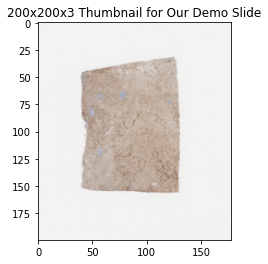


Slide Level Count: 3
Slide Level Dimensions: ((17928, 20126), (4482, 5031), (2241, 2515))
Slide Level Downsamples: (1.0, 4.000198767640628, 8.001192842942345)

Slide Properties:
['aperio.AppMag', 'aperio.DSR ID', 'aperio.Date', 'aperio.DisplayColor', 'aperio.Exposure Scale', 'aperio.Exposure Time', 'aperio.Filename', 'aperio.Focus Offset', 'aperio.ICC Profile', 'aperio.ImageID', 'aperio.Left', 'aperio.LineAreaXOffset', 'aperio.LineAreaYOffset', 'aperio.LineCameraSkew', 'aperio.MPP', 'aperio.OriginalHeight', 'aperio.OriginalWidth', 'aperio.ScanScope ID', 'aperio.SessonMode', 'aperio.StripeWidth', 'aperio.Time', 'aperio.Time Zone', 'aperio.Top', 'aperio.User', 'openslide.comment', 'openslide.level-count', 'openslide.level[0].downsample', 'openslide.level[0].height', 'openslide.level[0].tile-height', 'openslide.level[0].tile-width', 'openslide.level[0].width', 'openslide.level[1].downsample', 'openslide.level[1].height', 'openslide.level[1].tile-height', 'openslide.level[1].tile-width', 

In [5]:
# See Possible Methods/Attributes
print("openslide.OpenSlide Object Attributes")
for a in [attr for attr in dir(demo_slide) if attr[0]!="_"]: print("\t-", a)

# Walk through the attributes and print the relevant outputs and explain
# where required...
#    - Important ones are `dimensions`, `read_region()`, and `get_thumbnail()` in my opinion
print(f"\nSlide Associated Images:\n{demo_slide.associated_images}")
print(f"\nSlide Close: Calling this method will close the access to the object")
print("Slide Format: Returns vendor format. " \
      "Used independent of the object... i.e. by using on this " \
      f"filename we get ––> `{demo_slide.detect_format(demo_path)}`")
print(f"\nSlide Dimensions: {demo_slide.dimensions}")
print(f"Slide Best Level for Downsample: Not Applicable")
print(f"\nSlide Thumbnail:")
plt.imshow(np.asarray(demo_slide.get_thumbnail((200,200))))
plt.title(f"200x200x3 Thumbnail for Our Demo Slide")
plt.show()
print(f"\nSlide Level Count: {demo_slide.level_count}")
print(f"Slide Level Dimensions: {demo_slide.level_dimensions}")
print(f"Slide Level Downsamples: {demo_slide.level_downsamples}")
print(f"\nSlide Properties:\n{[k for k,v in demo_slide.properties.items()]}")
print(f"\nSlide Read Region: Return an image containing " \
      "the contents of the specified region")

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">2.3  VISUALIZE A REGION OF THE SLIDE</h3>

---

We also visualize a region directly to the right and above the first image
* Note, we only shift in the horizontal direction.. not the vertical.
    * This is partly so we can observe that we have moved the correct amount
    * We can clearly see the background delineation between the tissue continues on it's upwards path
    * Knowing this we see that tiling will work as expected
* We will also draw a bbox around these tiles on the downsampled slide to see the size comparison

In [ ]:
LOCATION = (3900,4300)
LEVEL = 0
SIZE = (1024,1024)

plt.figure(figsize=(16,16))
plt.imshow(np.asarray(demo_slide.read_region(location=LOCATION, level=LEVEL, size=SIZE), dtype=np.uint8))
plt.title(f"TL-LOC: {LOCATION}\nLEVEL:  {LEVEL}\nSIZE:   {SIZE}")
plt.show()

In [ ]:
SHIFTED_LOC = (LOCATION[0]+SIZE[0], LOCATION[1])

plt.figure(figsize=(16,16))
plt.imshow(np.asarray(demo_slide.read_region(location=SHIFTED_LOC, level=LEVEL, size=SIZE), dtype=np.uint8))
plt.title(f"TL-LOC: {SHIFTED_LOC}\nLEVEL:  {LEVEL}\nSIZE:   {SIZE}")
plt.show()

ALMOST_OUT_LOC = (SHIFTED_LOC[0], SHIFTED_LOC[1]-SIZE[1])

plt.figure(figsize=(16,16))
plt.imshow(np.asarray(demo_slide.read_region(location=ALMOST_OUT_LOC, level=LEVEL, size=SIZE), dtype=np.uint8))
plt.title(f"TL-LOC: {ALMOST_OUT_LOC}\nLEVEL:  {LEVEL}\nSIZE:   {SIZE}")
plt.show()

In [ ]:
# 8x Downscale
DOWNSCALE_TILE_SIZE = (128,128)
DOWNSCALE_LOC = (round(LOCATION[0]/8.0012), round(LOCATION[1]/8.0012))
DOWNSCALE_SHIFTED_LOC = (round(SHIFTED_LOC[0]/8.0012), round(SHIFTED_LOC[1]/8.0012))
ALMOST_OUT_LOC = (DOWNSCALE_SHIFTED_LOC[0], DOWNSCALE_SHIFTED_LOC[1]-DOWNSCALE_TILE_SIZE[1])

slide_img_8xdown = np.asarray(demo_slide.read_region(location=(0,0), level=2, size=demo_slide.level_dimensions[-1]).convert("RGB"), dtype=np.uint8)
slide_img_8xdown = cv2.rectangle(slide_img_8xdown, (DOWNSCALE_LOC), 
                                 (DOWNSCALE_LOC[0]+DOWNSCALE_TILE_SIZE[0], 
                                  DOWNSCALE_LOC[1]+DOWNSCALE_TILE_SIZE[1]), (128, 0, 255), 10)
slide_img_8xdown = cv2.rectangle(slide_img_8xdown, (DOWNSCALE_SHIFTED_LOC), 
                                 (DOWNSCALE_SHIFTED_LOC[0]+DOWNSCALE_TILE_SIZE[0], 
                                  DOWNSCALE_SHIFTED_LOC[1]+DOWNSCALE_TILE_SIZE[1]), (0, 255, 128), 10)
slide_img_8xdown = cv2.rectangle(slide_img_8xdown, (ALMOST_OUT_LOC), 
                                 (ALMOST_OUT_LOC[0]+DOWNSCALE_TILE_SIZE[0], 
                                  ALMOST_OUT_LOC[1]+DOWNSCALE_TILE_SIZE[1]), (255, 128, 0), 10)

plt.figure(figsize=(14,14))
plt.imshow(slide_img_8xdown)
plt.show()

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">2.4  TEST ALTERNATIVE METHOD USING NUMPY AND QPTIFF FILES</h3>

---


In [ ]:
# Check for qptiff files
print("LISTS OF QPTIFF FILES")
print("\t – ", [x for x in oof_paths if x.endswith(".qptiff")])
print("\t – ", [x for x in stn_yes_paths if x.endswith(".qptiff")])
print("\t – ", [x for x in stn_dim_paths if x.endswith(".qptiff")])
print("\t – ", [x for x in stn_no_paths if x.endswith(".qptiff")])
print("\t – ", [x for x in no_tis_paths if x.endswith(".qptiff")])

### OR ###
np_img = np.asarray(demo_slide.read_region((0,0), level=0, size=demo_slide.dimensions).convert('RGB'), dtype=np.uint8)
print(f"\nNUMPY ARRAY SHAPE BEFORE PADDING: {np_img.shape}")

# Pad to nearest divisor of tile size (similar to how .svs OpenSlide will work)
new_w = np.round(np_img.shape[1]/SIZE[0])*SIZE[0]
padding_w = int(new_w-np_img.shape[1])
new_h = np.round(np_img.shape[0]/SIZE[0])*SIZE[0]
padding_h = int(new_h-np_img.shape[0])
np_img = np.pad(np_img, pad_width=((0, padding_h), (0, padding_w), (0,0)))
print(f"NUMPY ARRAY SHAPE AFTER PADDING: {np_img.shape}")

# Clear Residual Memory
del new_w, new_h, padding_w, padding_h; gc.collect(); gc.collect();

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">2.5  VISUALIZE A REGION OF THE SLIDE LIKE BEFORE</h3>

---

In [ ]:
LOCATION = (3900,4300)
LEVEL = 0
SIZE = (1024,1024)

plt.figure(figsize=(16,16))
plt.imshow(np_img[LOCATION[1]:LOCATION[1]+SIZE[1], LOCATION[0]:LOCATION[0]+SIZE[0], :])
plt.title(f"TL-LOC: {LOCATION}\nLEVEL:  {LEVEL}\nSIZE:   {SIZE}")
plt.show()

In [ ]:
SHIFTED_LOC = (LOCATION[0]+SIZE[0], LOCATION[1])

plt.figure(figsize=(16,16))
plt.imshow(np_img[SHIFTED_LOC[1]:SHIFTED_LOC[1]+SIZE[1], SHIFTED_LOC[0]:SHIFTED_LOC[0]+SIZE[0], :])
plt.title(f"TL-LOC: {SHIFTED_LOC}\nLEVEL:  {LEVEL}\nSIZE:   {SIZE}")
plt.show()

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">2.6  TIMING COMPARISON</h3>

---

In [ ]:
%%time

for i in range(10):
    tmp_tile = np_img[SHIFTED_LOC[1]:SHIFTED_LOC[1]+SIZE[1], SHIFTED_LOC[0]:SHIFTED_LOC[0]+SIZE[0], :]

In [ ]:
%%time

for i in range(10):
    tmp_tile = demo_slide.read_region(location=SHIFTED_LOC, level=LEVEL, size=SIZE).convert('RGB')

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="heuristic">3&nbsp;&nbsp;HUERISTIC EXPLORATION</a>

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">3.1  GRAB DIFFERENT TYPES OF TILES FROM THE SLIDE</h3>

---

In [ ]:
background_tile = np_img[:SIZE[1], :SIZE[0], :]

# Tissue Location - (4100,4600)
tissue_tile = np_img[4600:4600+SIZE[1], 4100:4100+SIZE[0], :]

# End-Tissue will have black in it from padding
end_tissue_tile = np_img[-SIZE[1]:, -SIZE[0]:, :]

# Tissue Location - (3900,4300)
some_tissue_tile_1 = np_img[4300:4300+SIZE[1], 3900:3900+SIZE[0], :]

# Tissue Location - (3500,4000)
some_tissue_tile_2 = np_img[4000:4000+SIZE[1], 3500:3500+SIZE[0], :]

# Tissue Location - (3250,3750)
some_tissue_tile_3 = np_img[3750:3750+SIZE[1], 3250:3250+SIZE[0], :]

# Tissue Location - (3150,3700)
some_tissue_tile_4 = np_img[3700:3700+SIZE[1], 3150:3150+SIZE[0], :]

# Tissue Location - (3110,3660)
some_tissue_tile_5 = np_img[3660:3660+SIZE[1], 3110:3110+SIZE[0], :]

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">3.2  DEFINE BASIC HEURISTIC FUNCTION</h3>

---

In [ ]:
def no_tissue_heuristic(np_tile, upper_thresh=200, lower_thresh=1, heuristic_ratio_boundary=0.005):
    """ Function to heuristically determine if no tissue is present for a given tile
    
    Args:
        np_tile (nd.array(uint8)): A numpy array representing the tile
        upper_thresh (int, optional): The upper threshold for considering valid `tissue pixels`
        lower_thresh (int, optional): The lower threshold for considering valid `tissue pixels`
        heuristic_ratio (float, optional): The number of pixels with values between
            `lower_thresh` and `upper_thresh` in the whole image as a ratio of the
            total number of pixels present in the tile. 
                - i.e. 0.005 for a 1024x1024x3 image (3,145,728 pixels), indicates
                  that 15729 pixels are allowed to have values between `lower_thresh` 
                  and `upper_thresh`... if more pixels have values (more colour, etc.),
                  then the image is heuristically determiend to NOT BE BACKGROUND.
    
    Returns:
        A bool indicating whether or not the tile contains tissue.
            - True is indicative of NO-TISSUE being present
            - False is indicative of SOME-TISSUE being present
    """
    # find frequency of pixels in range 0-255 
    histr, _ = np.histogram(np_tile.ravel(),256,[0,256]) 
    histr_sum = histr[lower_thresh:upper_thresh].sum()
    image_pixel_count = np.product(np_tile.shape)
    heuristic_ratio_calc = histr_sum/image_pixel_count
    
    if heuristic_ratio_calc>heuristic_ratio_boundary:
        return False
    else:
        return True

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">3.3  VISUALIZE HEURISTIC HISTOGRAM PLOTS</h3>

---

In [ ]:
# find frequency of pixels in range 0-255 

histr, _ = np.histogram(background_tile.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(background_tile)}\n")
# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(background_tile, cmap="gray")
plt.title("Background Tile - Image")
plt.subplot(1, 2, 2)
plt.plot(histr) 
plt.ylim(-500, 30000)
plt.title(f"Background Tile - Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show()

# find frequency of pixels in range 0-255 
histr, _ = np.histogram(end_tissue_tile.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(end_tissue_tile)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(end_tissue_tile)
plt.title("End-Tissue Tile - Image")
plt.subplot(1, 2, 2)
plt.plot(histr) 
plt.ylim(-500, 30000)
plt.title(f"End-Tissue Tile - Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show()
  
# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(end_tissue_tile)
plt.title("End-Tissue Tile - Image")
plt.subplot(1, 2, 2)
plt.plot(histr[1:]) 
plt.ylim(-500, 30000)
plt.title(f"End-Tissue Tile - Histogram – Sum-Under-200-Excluding-0={histr[1:200].sum()}")
plt.show()

# find frequency of pixels in range 0-255 
histr, _ = np.histogram(tissue_tile.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(tissue_tile)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(tissue_tile)
plt.title("Tissue Tile - Image")
plt.subplot(1, 2, 2)
plt.plot(histr)
plt.ylim(-500, 30000)
plt.title(f"Tissue Tile – Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show() 

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(tissue_tile)
plt.title("Tissue Tile - Image")
plt.subplot(1, 2, 2)
plt.plot(histr[1:])
plt.ylim(-500, 30000)
plt.title(f"Tissue Tile – Histogram – Sum-Under-200-Excluding-0={histr[1:200].sum()}")
plt.show() 

# find frequency of pixels in range 0-255 
histr, _ = np.histogram(some_tissue_tile_1.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(some_tissue_tile_1)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(some_tissue_tile_1)
plt.title("Some-Tissue Tile-1 - Image")
plt.subplot(1, 2, 2)
plt.plot(histr)
plt.ylim(-500, 30000)
plt.title(f"Some-Tissue Tile-1 – Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show() 

# find frequency of pixels in range 0-255 
histr, _ = np.histogram(some_tissue_tile_2.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(some_tissue_tile_2)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(some_tissue_tile_2)
plt.title("Some-Tissue Tile-2 - Image")
plt.subplot(1, 2, 2)
plt.plot(histr)
plt.ylim(-500, 30000)
plt.title(f"Some-Tissue Tile-2 – Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show() 

# find frequency of pixels in range 0-255 
histr, _ = np.histogram(some_tissue_tile_3.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(some_tissue_tile_3)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(some_tissue_tile_3)
plt.title("Some-Tissue Tile-3 - Image")
plt.subplot(1, 2, 2)
plt.plot(histr)
plt.ylim(-500, 30000)
plt.title(f"Some-Tissue Tile-3 – Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show() 

# find frequency of pixels in range 0-255 
histr, _ = np.histogram(some_tissue_tile_4.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(some_tissue_tile_4)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(some_tissue_tile_4)
plt.title("Some-Tissue Tile-4 - Image")
plt.subplot(1, 2, 2)
plt.plot(histr)
plt.ylim(-500, 30000)
plt.title(f"Some-Tissue Tile-4 – Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show() 


# find frequency of pixels in range 0-255 
histr, _ = np.histogram(some_tissue_tile_5.ravel(),256,[0,256])
print(f"\nNO TISSUE PRESENT (HEURISTIC) --> {no_tissue_heuristic(some_tissue_tile_5)}\n")

# show the plotting graph of an image 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.imshow(some_tissue_tile_5)
plt.title("Some-Tissue Tile-5 - Image")
plt.subplot(1, 2, 2)
plt.plot(histr)
plt.ylim(-500, 30000)
plt.title(f"Some-Tissue Tile-5 – Histogram – Sum-Under-200={histr[:200].sum()}")
plt.show() 

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="class_viz">4&nbsp;&nbsp;CLASSWISE VISUALIZATION</a>

In [ ]:
def visualize_all_thumbnails(list_of_paths, thumb_size=(500,500), n_cols=4):
    """TBD"""
    
    # Setup
    n_rows = (len(list_of_paths)//n_cols)+1
    fig = plt.figure(figsize=(5*n_cols, 6*n_rows), tight_layout=True)
                           
    # Loop
    for i, path in enumerate(list_of_paths):
        thumbnail = np.asarray(openslide.OpenSlide(path).get_thumbnail(thumb_size), dtype=np.uint8)
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        ax.imshow(thumbnail)
        plt.title(f"Name: {path.rsplit('/', 1)[1]}" \
                  f"\nIndex=[{i}]", fontweight="bold")
        ax.axis('off')
    plt.show()
    
print("\n\n--------------------------------\nHE TISSUE IN-FOCUS SLIDES\n--------------------------------\n\n")
visualize_all_thumbnails(he_tis_paths)

print("\n\n\n\n\n--------------------------------\nOUT-OF-FOCUS SLIDES\n--------------------------------\n\n")
visualize_all_thumbnails(oof_paths)

# .... etc ...

<br>

<a style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;" id="slide_classification">5&nbsp;&nbsp;HEURISTIC FOR SLIDE CLASSIFICATION FROM TILE LABELS</a>

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">5.1  LOAD NAME MAP AND AUTOML EXPORTS</h3>

---

In [6]:
# Create name map dataframe
NAME_MAP_DIR = "/home/jupyter/files/"
AUTOML_OUTPUT_DIR = "/home/jupyter/files/"

name_map_df = pd.concat([
    pd.read_csv(os.path.join(NAME_MAP_DIR, f_name)) \
    for f_name in os.listdir(NAME_MAP_DIR) \
    if f_name.startswith("name_map")
]).reset_index(drop=True)

# Create AUTOML prediction dataframe
df = pd.concat([
    pd.read_csv(
        os.path.join(AUTOML_OUTPUT_DIR, f_name), 
        names=["subset", "path", "label"]
    ) for f_name in os.listdir(AUTOML_OUTPUT_DIR) \
    if f_name.startswith("image_classification")
]).reset_index(drop=True)


# df = pd.concat([
#     pd.read_csv("/home/jupyter/files/image_classification_1.csv", names=["subset", "path", "label"]),
#     pd.read_csv("/home/jupyter/files/image_classification_2.csv", names=["subset", "path", "label"]),
#     pd.read_csv("/home/jupyter/files/image_classification_3.csv", names=["subset", "path", "label"]),
#     pd.read_csv("/home/jupyter/files/image_classification_4.csv", names=["subset", "path", "label"])
# ]).reset_index(drop=True)
df["bucket_name"] = df["path"].apply(lambda x: x[5:].split("/", 1)[0])
df["blob_name"] = df["path"].apply(lambda x: x[5:].split("/", 1)[1])
df.drop(columns=["subset", "path"], inplace=True)

# Create Name Map Dictionary
name_map_df["full_path"] = name_map_df["full_path"].apply(lambda x: x.split(".", 1)[0])
name_map_df["alias"] = name_map_df["alias"].apply(lambda x: x.split(".", 1)[0])
display(name_map_df)

# Create Mapping Dictionaries for File Names
original_2_alias = {original:alias for original, alias in zip(name_map_df.full_path.values, name_map_df.alias.values)}
alias_2_original = {v:k for k,v in original_2_alias.items()}

display(df)

,full_path,alias
0,11606,img_200
1,7373,img_201
2,AVD-B1VOV-2579A,img_202
3,AVD-B1VOV-3267A,img_203
4,AVD-B1VOV-3450A,img_204
...,...,...
62,29888,img_055
63,29877,img_056
64,29890,img_057
65,29841,img_058


,label,bucket_name,blob_name
0,out_of_focus,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
1,strong_positive,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
2,out_of_focus,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
3,strong_positive,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
4,out_of_focus,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
...,...,...,...
22262,no_tissue,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
22263,no_tissue,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
22264,no_tissue,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...
22265,negative,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...


<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">5.2  UPDATE METADATA (or retrieve existing csv)</h3>

---

In [7]:
def get_metadata(row):
    """ Functio to retrieve metadata from GCS files """
    storage_client = storage.Client()
    bucket = storage_client.bucket(row["bucket_name"])
    try:
        blob = bucket.get_blob(row["blob_name"])
        meta = blob.metadata
        row["x_coord"] = int(meta["x_coord"])
        row["y_coord"] = int(meta["y_coord"])
        row["slide_name"] = meta["slide_name"]
        row["slide_label"] = meta["slide_label"]
        if row.name%250==0:
            print(f"Row {row.name}/22267 Complete")
    except:
        print(f'Problem at {row["bucket_name"]} - {row["blob_name"]}')
    return row

if not os.path.isfile("/home/jupyter/files/updated_meta_for_heuristic.csv"):
    df = df.apply(get_metadata, axis=1)
    # ########## THIS SHOULD NOR BE REQUIRED #########
    df.label.fillna(df.slide_label, inplace=True)
    ##################################################
    df.label = df.label.str.lower()
    df["slide_name_original"] = df["slide_name"].apply(lambda x: alias_2_original[x])
    df.to_csv("/home/jupyter/files/updated_meta_for_heuristic.csv", index=False)
else:
    df = pd.read_csv("/home/jupyter/files/updated_meta_for_heuristic.csv")

# Fix the one mislabelled slide
df[df.slide_name=="img_048"]["slide_label"] = "he"
    
display(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,label,bucket_name,blob_name,x_coord,y_coord,slide_name,slide_label,slide_name_original
0,out_of_focus,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,30720,18432,img_008,out_of_focus,42678
1,strong_positive,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,6144,16384,img_031,strong_positive,SGN010B_APD ML1710353B 20191108 CD228 ^1132898
2,out_of_focus,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,20480,12288,img_011,out_of_focus,42677
3,strong_positive,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,8192,10240,img_013,strong_positive,SGN010B_APD ML1407166A 20191107 CD228 ^1132440
4,out_of_focus,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,49152,22528,img_001,out_of_focus,42684
...,...,...,...,...,...,...,...,...
22262,no_tissue,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,48128,35840,img_005,out_of_focus,30040
22263,no_tissue,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,14336,40960,img_055,no_tissue,29888
22264,no_tissue,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,75776,4096,img_057,no_tissue,29890
22265,negative,seagen-quantiphi,export_data-all_subsets_combined-2021-01-14T12...,23552,4096,img_051,negative,SGN010B_APD ML1809143A 20191112 CD228 ^1131976


<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">5.3  HIGH LEVEL OVERVIEW</h3>

---

In [9]:
def num_to_frac(row):
    for label in row.keys():
        row[label] = row[label]/row["total_count"]
    return row

# GET COUNTS FOR EACH SLIDE
ave_df = df.groupby(["slide_label", "label"])["bucket_name"].count().unstack(level=1).fillna(0)
ave_df["total_count"] = ave_df.sum(axis=1)
print("\n\n------------------------------")
print("    COUNTS FOR EACH SLIDE")
print("------------------------------\n")
display(ave_df)


# CONVERT COUNTS TO PERCENTAGES
ave_df = ave_df.apply(num_to_frac, axis=1)
ave_df.drop(columns="total_count", inplace=True)

print("\n\n-----------------------------------")
print("    PERCENTAGES FOR EACH SLIDE")
print("-----------------------------------\n")
display(ave_df)



------------------------------
    COUNTS FOR EACH SLIDE
------------------------------



label,dim_positive,he,necrotic,negative,no_tissue,out_of_focus,strong_positive,total_count
slide_label,,,,,,,,
dim_positive,1157.0,0.0,172.0,187.0,147.0,0.0,22.0,1685.0
negative,117.0,961.0,168.0,2936.0,408.0,1.0,0.0,4591.0
no_tissue,0.0,0.0,1.0,0.0,2322.0,1.0,0.0,2324.0
out_of_focus,14.0,2707.0,2.0,1.0,1355.0,5216.0,17.0,9312.0
strong_positive,384.0,0.0,353.0,104.0,428.0,10.0,3076.0,4355.0




-----------------------------------
    PERCENTAGES FOR EACH SLIDE
-----------------------------------



label,dim_positive,he,necrotic,negative,no_tissue,out_of_focus,strong_positive
slide_label,,,,,,,
dim_positive,0.686647,0.000000,0.102077,0.110979,0.087240,0.000000,0.013056
negative,0.025485,0.209323,0.036593,0.639512,0.088870,0.000218,0.000000
no_tissue,0.000000,0.000000,0.000430,0.000000,0.999139,0.000430,0.000000
out_of_focus,0.001503,0.290700,0.000215,0.000107,0.145511,0.560137,0.001826
strong_positive,0.088175,0.000000,0.081056,0.023881,0.098278,0.002296,0.706315


<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">5.4  DETAIL LEVEL OVERVIEW</h3>

---

In [10]:
# GET COUNTS FOR EACH SLIDES TILE LEVEL LABELS
df["slide_name_w_label"] = df["slide_name"]+"_"+df["slide_label"]
detail_df = df.groupby(["slide_label", "label", "slide_name"])["bucket_name"].count().unstack(level=1).fillna(0)
detail_df["total_count"] = detail_df.sum(axis=1)

print("\n\n------------------------------------------------")
print("    COUNTS FOR EACH SLIDE'S TILE LEVEL LABELS")
print("------------------------------------------------\n")
display(detail_df)


# CONVERT COUNTS TO PERCENTAGES
detail_df = detail_df.apply(num_to_frac, axis=1)
detail_df.drop(columns="total_count", inplace=True)

print("\n\n-----------------------------------")
print("    PERCENTAGES FOR EACH SLIDE")
print("-----------------------------------\n")
display(detail_df)

print("\n\n------------------------------------------------")
print("    STATS FOR EACH SLIDE LEVEL ANNOTATION ")
print("-----------------------------------------------\n")
for c in detail_df.index.get_level_values(0).unique():
    print("\n============================")
    print(f" {c.upper()} SLIDE STATS")
    print("============================\n")
    stats_df = detail_df.loc[c].describe().T[["min", "mean", "max"]]
    display(stats_df)
    print("\n")



------------------------------------------------
    COUNTS FOR EACH SLIDE'S TILE LEVEL LABELS
------------------------------------------------



label                       dim_positive      he  necrotic  negative  \
slide_label     slide_name                                             
dim_positive    img_033            114.0     0.0      18.0      11.0   
                img_034             22.0     0.0       8.0       0.0   
                img_035             52.0     0.0      24.0       8.0   
                img_036             96.0     0.0       0.0       0.0   
                img_037             56.0     0.0       0.0      39.0   
                img_038            132.0     0.0      16.0       1.0   
                img_039            155.0     0.0      79.0       4.0   
                img_040             89.0     0.0      16.0      84.0   
                img_041            172.0     0.0      10.0      29.0   
                img_042            269.0     0.0       1.0      11.0   
negative        img_043              6.0     0.0       1.0     120.0   
                img_044              0.0     0.0      77.0     269.0   
                img_045              0.0     0.0       1.0     214.0   
                img_046              0.0     0.0       6.0     338.0   
                img_047              6.0     0.0       5.0     116.0   
                img_048              0.0   961.0       0.0       0.0   
                img_049            103.0     0.0      24.0    1370.0   
                img_050              0.0     0.0      53.0     310.0   
                img_051              2.0     0.0       1.0     115.0   
                img_052              0.0     0.0       0.0      84.0   
no_tissue       img_053              0.0     0.0       1.0       0.0   
                img_054              0.0     0.0       0.0       0.0   
                img_055              0.0     0.0       0.0       0.0   
                img_056              0.0     0.0       0.0       0.0   
                img_057              0.0     0.0       0.0       0.0   
                img_058              0.0     0.0       0.0       0.0   
                img_059              0.0     0.0       0.0       0.0   
out_of_focus    img_000              0.0     7.0       0.0       0.0   
                img_001              0.0   856.0       0.0       0.0   
                img_002              0.0     0.0       0.0       0.0   
                img_003             14.0     0.0       0.0       1.0   
                img_004              0.0  1319.0       0.0       0.0   
                img_005              0.0     0.0       2.0       0.0   
                img_006              0.0     4.0       0.0       0.0   
                img_007              0.0     0.0       0.0       0.0   
                img_008              0.0     0.0       0.0       0.0   
                img_009              0.0    53.0       0.0       0.0   
                img_010              0.0   468.0       0.0       0.0   
                img_011              0.0     0.0       0.0       0.0   
                img_012              0.0     0.0       0.0       0.0   
strong_positive img_013              0.0     0.0       0.0       0.0   
                img_014              6.0     0.0       1.0       0.0   
                img_015             15.0     0.0      33.0       0.0   
                img_016             10.0     0.0      14.0       0.0   
                img_017             42.0     0.0      18.0       4.0   
                img_018              0.0     0.0      25.0       0.0   
                img_019             12.0     0.0      43.0       0.0   
                img_020             29.0     0.0       0.0       5.0   
                img_021              0.0     0.0       0.0       1.0   
                img_022              7.0     0.0       0.0       0.0   
                img_023              3.0     0.0      15.0      23.0   
                img_024              9.0     0.0      24.0       0.0   
                img_025              0.0     0.0       5.0       0.0   
                img_026            122.0



-----------------------------------
    PERCENTAGES FOR EACH SLIDE
-----------------------------------



label                       dim_positive        he  necrotic  negative  \
slide_label     slide_name                                               
dim_positive    img_033         0.760000  0.000000  0.120000  0.073333   
                img_034         0.578947  0.000000  0.210526  0.000000   
                img_035         0.468468  0.000000  0.216216  0.072072   
                img_036         0.888889  0.000000  0.000000  0.000000   
                img_037         0.509091  0.000000  0.000000  0.354545   
                img_038         0.830189  0.000000  0.100629  0.006289   
                img_039         0.610236  0.000000  0.311024  0.015748   
                img_040         0.432039  0.000000  0.077670  0.407767   
                img_041         0.761062  0.000000  0.044248  0.128319   
                img_042         0.832817  0.000000  0.003096  0.034056   
negative        img_043         0.042553  0.000000  0.007092  0.851064   
                img_044         0.000000  0.000000  0.196931  0.687980   
                img_045         0.000000  0.000000  0.004444  0.951111   
                img_046         0.000000  0.000000  0.016349  0.920981   
                img_047         0.043478  0.000000  0.036232  0.840580   
                img_048         0.000000  0.864986  0.000000  0.000000   
                img_049         0.064739  0.000000  0.015085  0.861094   
                img_050         0.000000  0.000000  0.137662  0.805195   
                img_051         0.013514  0.000000  0.006757  0.777027   
                img_052         0.000000  0.000000  0.000000  0.893617   
no_tissue       img_053         0.000000  0.000000  0.003425  0.000000   
                img_054         0.000000  0.000000  0.000000  0.000000   
                img_055         0.000000  0.000000  0.000000  0.000000   
                img_056         0.000000  0.000000  0.000000  0.000000   
                img_057         0.000000  0.000000  0.000000  0.000000   
                img_058         0.000000  0.000000  0.000000  0.000000   
                img_059         0.000000  0.000000  0.000000  0.000000   
out_of_focus    img_000         0.000000  0.007964  0.000000  0.000000   
                img_001         0.000000  0.631268  0.000000  0.000000   
                img_002         0.000000  0.000000  0.000000  0.000000   
                img_003         0.011580  0.000000  0.000000  0.000827   
                img_004         0.000000  0.848232  0.000000  0.000000   
                img_005         0.000000  0.000000  0.006711  0.000000   
                img_006         0.000000  0.012346  0.000000  0.000000   
                img_007         0.000000  0.000000  0.000000  0.000000   
                img_008         0.000000  0.000000  0.000000  0.000000   
                img_009         0.000000  0.084800  0.000000  0.000000   
                img_010         0.000000  0.772277  0.000000  0.000000   
                img_011         0.000000  0.000000  0.000000  0.000000   
                img_012         0.000000  0.000000  0.000000  0.000000   
strong_positive img_013         0.000000  0.000000  0.000000  0.000000   
                img_014         0.055556  0.000000  0.009259  0.000000   
                img_015         0.042735  0.000000  0.094017  0.000000   
                img_016         0.034483  0.000000  0.048276  0.000000   
                img_017         0.358974  0.000000  0.153846  0.034188   
                img_018         0.000000  0.000000  0.071225  0.000000   
                img_019         0.046875  0.000000  0.167969  0.000000   
                img_020         0.256637  0.000000  0.000000  0.044248   
                img_021         0.000000  0.000000  0.000000  0.003817   
                img_022         0.071429  0.000000  0.000000  0.000000   
                img_023         0.029126  0.000000  0.145631  0.223301   
                img_024         0.025937  0.000000  0.069164  0.000000   
    



------------------------------------------------
    STATS FOR EACH SLIDE LEVEL ANNOTATION 
-----------------------------------------------


 DIM_POSITIVE SLIDE STATS



,min,mean,max
label,,,
dim_positive,0.432039,0.667174,0.888889
he,0.000000,0.000000,0.000000
necrotic,0.000000,0.108341,0.311024
negative,0.000000,0.109213,0.407767
no_tissue,0.046667,0.105631,0.243243
out_of_focus,0.000000,0.000000,0.000000
strong_positive,0.000000,0.009641,0.046440





 NEGATIVE SLIDE STATS



,min,mean,max
label,,,
dim_positive,0.000000,0.016428,0.064739
he,0.000000,0.086499,0.864986
necrotic,0.000000,0.042055,0.196931
negative,0.000000,0.758865,0.951111
no_tissue,0.044444,0.096063,0.202703
out_of_focus,0.000000,0.000090,0.000900
strong_positive,0.000000,0.000000,0.000000





 NO_TISSUE SLIDE STATS



,min,mean,max
label,,,
dim_positive,0.00000,0.000000,0.000000
he,0.00000,0.000000,0.000000
necrotic,0.00000,0.000489,0.003425
negative,0.00000,0.000000,0.000000
no_tissue,0.99635,0.998989,1.000000
out_of_focus,0.00000,0.000521,0.003650
strong_positive,0.00000,0.000000,0.000000





 OUT_OF_FOCUS SLIDE STATS



,min,mean,max
label,,,
dim_positive,0.000000,0.000891,0.011580
he,0.000000,0.181299,0.848232
necrotic,0.000000,0.000516,0.006711
negative,0.000000,0.000064,0.000827
no_tissue,0.051282,0.260038,0.949664
out_of_focus,0.043624,0.555937,0.935484
strong_positive,0.000000,0.001255,0.015489





 STRONG_POSITIVE SLIDE STATS



,min,mean,max
label,,,
dim_positive,0.000000,0.091137,0.358974
he,0.000000,0.000000,0.000000
necrotic,0.000000,0.068020,0.251889
negative,0.000000,0.029646,0.223301
no_tissue,0.041985,0.110028,0.269531
out_of_focus,0.000000,0.001851,0.023438
strong_positive,0.335013,0.699318,0.954198


<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff; font-variant: small-caps;">5.5  DECISION TREE</h3>

---

We do the following:
1. Prepare the Dataset
1. Train the Decision Tree
1. Visualize the Decision Tree
1. Create Heuristic Function From Decision Tree

THESE ARE THE SLIDE LEVEL LABELS YOU WILL BE ANALYSING: ['dim_positive' 'negative' 'no_tissue' 'out_of_focus' 'strong_positive']
THESE ARE THE SLIDE LEVEL LABELS AS INTEGERS: {'dim_positive': 0, 'negative': 1, 'no_tissue': 2, 'out_of_focus': 3, 'strong_positive': 4}

TRAIN X SHAPE: (60, 7)
TRAIN Y SHAPE: (60,)


TRAIN EX 1     - LABEL    :
	– 0 or dim_positive

TRAIN EX 1 - VARIABLES: 
	– VARIABLE 1: 0.7599999904632568
	– VARIABLE 2: 0.0
	– VARIABLE 3: 0.11999999731779099
	– VARIABLE 4: 0.07333333045244217
	– VARIABLE 5: 0.046666666865348816
	– VARIABLE 6: 0.0
	– VARIABLE 7: 0.0


TRAIN EX 21     - LABEL    :
	– 2 or no_tissue

TRAIN EX 21 - VARIABLES: 
	– VARIABLE 1: 0.0
	– VARIABLE 2: 0.0
	– VARIABLE 3: 0.0034246575087308884
	– VARIABLE 4: 0.0
	– VARIABLE 5: 0.9965753555297852
	– VARIABLE 6: 0.0
	– VARIABLE 7: 0.0


TRAIN EX 41     - LABEL    :
	– 4 or strong_positive

TRAIN EX 41 - VARIABLES: 
	– VARIABLE 1: 0.0
	– VARIABLE 2: 0.0
	– VARIABLE 3: 0.0
	– VARIABLE 4: 0.0
	– VARIABLE 5:

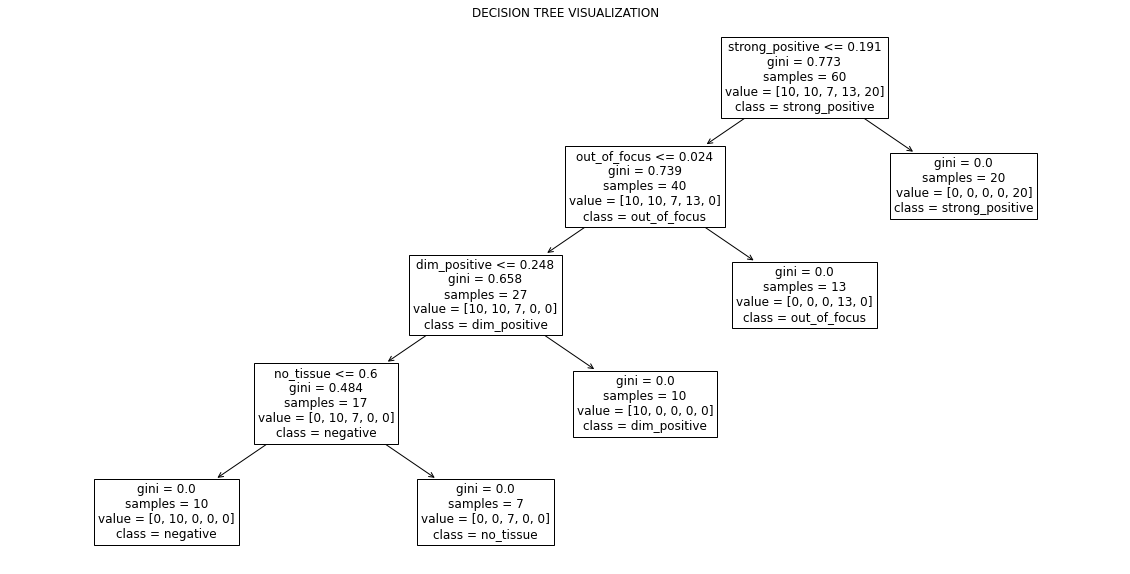




--------------------------------------------------------------------------------------------------------------------------------------------


                     >>>> DECISION TREE HEURISTIC FUNCTION <<<<<

def heuristic_slide_label(dim_positive, he, necrotic, negative, no_tissue, out_of_focus, strong_positive):
    if strong_positive <= 0.19072610698640347:
        if out_of_focus <= 0.023636898840777576:
            if dim_positive <= 0.24838900193572044:
                if no_tissue <= 0.5995265245437622:
                    return [[ 0. 10.  0.  0.  0.]]
                else:  # if no_tissue > 0.5995265245437622
                    return [[0. 0. 7. 0. 0.]]
            else:  # if dim_positive > 0.24838900193572044
                return [[10.  0.  0.  0.  0.]]
        else:  # if out_of_focus > 0.023636898840777576
            return [[ 0.  0.  0. 13.  0.]]
    else:  # if strong_positive > 0.19072610698640347
        return [[ 0.  0.  0.  0. 20.]]



------------------------

In [86]:
# MANUALLY DEFINE OR ALLOW AUTODEFINE FROM DETAIL DATAFRAME
LABELS = [] 
if not LABELS: LABELS=detail_df.index.unique(level=0).values
label_map = {label:i for i, label in enumerate(LABELS)}
label_map_reverse = {v:k for k,v in label_map.items()}
    
print("THESE ARE THE SLIDE LEVEL LABELS YOU WILL BE ANALYSING: " \
      f"{LABELS}")
print("THESE ARE THE SLIDE LEVEL LABELS AS INTEGERS: " \
      f"{label_map}")

# Initialize training arrays
train_x = np.zeros((len(detail_df), detail_df.shape[1]), dtype=np.float32)
train_y = np.zeros((len(detail_df),), dtype=np.uint8)

print(f"\nTRAIN X SHAPE: {train_x.shape}")
print(f"TRAIN Y SHAPE: {train_y.shape}")

# Initialize running total index
run_idx = 0

# Iterate over slide-level labels and build training data
for label in LABELS:
    sub_df_np = detail_df.loc[label].to_numpy()
    
    # Get number of examples at slide level
    n_idx = sub_df_np.shape[0]
    
    train_x[run_idx:run_idx+n_idx, :] = sub_df_np
    train_y[run_idx:run_idx+n_idx] = label_map[label]
    
    # Updating running index
    run_idx+=n_idx
    
for i in range(0,60,20):
    print(f"\n\nTRAIN EX {i+1}     - LABEL    :\n\t– {train_y[i]} or {label_map_reverse[train_y[i]]}")
    print(f"\nTRAIN EX {i+1} - VARIABLES: ")
    for i, var in enumerate(train_x[i]): print(f"\t– VARIABLE {i+1}: {var}")

print("\n\n\n----------------------------------------------------------------------" \
      "----------------------------------------------------------------------\n\n\n")
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)

plt.figure(figsize=(20,10))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=12, feature_names=detail_df.columns, class_names=LABELS)
plt.title("DECISION TREE VISUALIZATION")
plt.show()

print("\n\n\n----------------------------------------------------------------------" \
      "----------------------------------------------------------------------\n\n")

print("                     >>>> DECISION TREE HEURISTIC FUNCTION <<<<<\n")

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def heuristic_slide_label({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

tree_to_code(clf, detail_df.columns)

print("\n\n\n----------------------------------------------------------------------" \
      "----------------------------------------------------------------------\n\n")

**GENERATE FINAL TRAINING/VALIDATION DATASET**

In [94]:
# Identify Validation Files At Slide Level
val_he_name = he_tis_paths[1].rsplit("/", 1)[1].rsplit(".", 1)[0]
val_no_tissue_name = no_tis_paths[1].rsplit("/", 1)[1].rsplit(".", 1)[0]
val_oof_name = oof_paths[1].rsplit("/", 1)[1].rsplit(".", 1)[0]
val_file_names = [val_he_name, val_no_tissue_name, val_oof_name]

# MAKE TRAIN & VALIDATION DF
train_df=df[~df.slide_name_original.isin(val_file_names)]
val_df=df[df.slide_name_original.isin(val_file_names)]

# MAKE INITIAL AUTOML DF (FROM VAL DF)
print(f"\nTRAIN AUTOML DF HAS {len(val_df)} FEWER ROWS THAN ORIGINAL DF (3 SLIDES WORTH)")
print("TRAIN AUTOML DF REQUIRES 10 ROWS LABELED AS `VALIDATION` AND 10 ROWS LABELLED AS `TEST`... THE REST CAN BE `TRAIN`\n")

automl_train_df = train_df[["label", "bucket_name", "blob_name"]]
automl_train_df["split"] = "TRAIN"

automl_val_df = val_df[["label", "bucket_name", "blob_name"]]
automl_val_df["split"] = "TRAIN" # NOT NEEDED... BUT FOR CONSISTENCY

# UPDATE 1 TILE PER CLASS FOR VALIDATION AND TEST STATUS (MIN REQUIRED)
for label in detail_df.columns:
    automl_random_sample = automl_train_df[automl_train_df.label==label].sample(2)
    automl_random_sample.iloc[0]["split"] = "VALIDATION"
    automl_random_sample.iloc[1]["split"] = "TEST"
    automl_train_df.update(automl_random_sample,)

# UPDATE PATH
automl_train_df["path"] = automl_train_df.apply(lambda x: os.path.join("gs://", x["bucket_name"], x["blob_name"]), axis=1)
automl_val_df["path"] = automl_val_df.apply(lambda x: os.path.join("gs://", x["bucket_name"], x["blob_name"]), axis=1)

# DROP UNNECESSARY COLUMNS & REORDER
automl_train_df = automl_train_df[["split", "path", "label"]]
automl_val_df = automl_val_df[["split", "path", "label"]]

# REPLACE NECROTIC LABEL WITH EXCLUSION
automl_train_df["label"] = automl_train_df["label"].apply(lambda x: x.replace("necrotic", "exclusion"))
automl_val_df["label"] = automl_val_df["label"].apply(lambda x: x.replace("necrotic", "exclusion"))

# GENERATE CSVS
automl_train_df.to_csv(
    os.path.join("/home/jupyter/new_csvs", "train_automl.csv"), 
    index=False, header=False, encoding="utf-8")
automl_val_df.to_csv(
    os.path.join("/home/jupyter/new_csvs", "val_automl.csv"), 
    index=False, header=False, encoding="utf-8")

display(automl_train_df)


TRAIN AUTOML DF HAS 1728 FEWER ROWS THAN ORIGINAL DF (3 SLIDES WORTH)
TRAIN AUTOML DF REQUIRES 10 ROWS LABELED AS `VALIDATION` AND 10 ROWS LABELLED AS `TEST`... THE REST CAN BE `TRAIN`



,split,path,label
0,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus
1,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,strong_positive
2,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus
3,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,strong_positive
5,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,out_of_focus
...,...,...,...
22262,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue
22263,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue
22264,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,no_tissue
22265,TRAIN,gs://seagen-quantiphi/export_data-all_subsets_...,negative


In [97]:
# !gsutil -m cp -r ./new_csvs/* gs://seagen-quantiphi/new_automl_csvs

Copying file://./new_csvs/val_automl.csv [Content-Type=text/csv]...
Copying file://./new_csvs/train_automl.csv [Content-Type=text/csv]...           
/ [2/2 files][  3.1 MiB/  3.1 MiB] 100% Done                                    
Operation completed over 2 objects/3.1 MiB.                                      


**HELPER FUNCTION FOR VISUALIZING MODEL INFERENCE FILES**

In [ ]:
def get_gs_paths(root_dir):
    svs_files = !gsutil ls -r {root_dir}/**/*.svs
    qptiff_files = !gsutil ls -r {root_dir}/**/*.qptiff
    return svs_files+qptiff_files

def make_gt_labels(all_gs_paths):
    df = pd.read_csv("/home/jupyter/files/updated_meta_for_heuristic.csv")
    df = df[["x_coord", "y_coord", "label", "slide_name_original"]]
    for file_path in all_gs_paths:
        f_name_original = file_path.rsplit("/", 1)[1].rsplit(".", 1)[0]
        sub_df = df[df.slide_name_original==f_name_original]
        sub_df["slide_path"] = file_path
        sub_df = sub_df.rename(columns={"x_coord": "x_coords", "y_coord": "y_coords", "label": "preds"})
        sub_df = sub_df[["slide_path", "x_coords", "y_coords", "preds"]]
        sub_df.to_csv(f"/home/jupyter/viz_tutorial/csvs/gt_labels/{f_name_original}.csv", index=False)
        
# make_gt_labels(get_gs_paths("gs://ihc_dataset/Quantiphi/completed"))